# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
from collections import namedtuple
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
#from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.7)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Among Us data

We will start with some toy (literally) data consisting of x images of Among Us.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

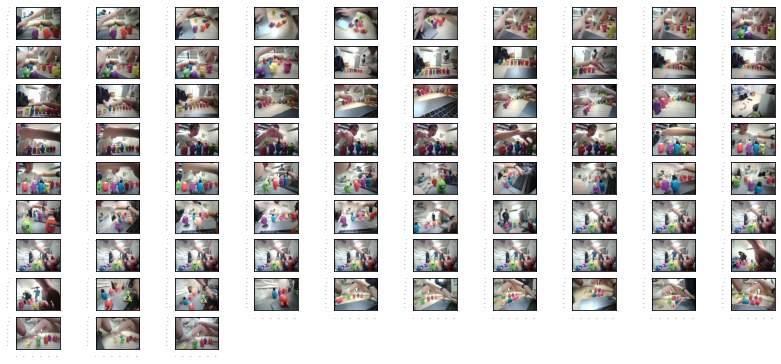

In [10]:
# Load images and visualize
train_image_dir = '/Users/i541891/Documents/among_us_detection/workspace/images/train'
train_images_np = []

def download_images():
    base_path = '/Users/i541891/Documents/among_us_detection/workspace/images/train/'
    image_paths = sorted(glob.glob(f'{base_path}*.jpg',))
    return image_paths

IMAGE_PATHS = download_images()
#print(IMAGE_PATHS)
for image_path in IMAGE_PATHS:
    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(10, 10, idx+1)
    plt.imshow(train_image_np)
plt.show()

# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [4]:
xml_list = []
path = '/Users/i541891/Documents/among_us_detection/workspace/images/train'
def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in sorted(glob.glob(path + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

examples = xml_to_csv(path)
grouped = split(examples, "filename")
gt_boxes = []
for group in grouped:
    group.object['ymin'] = group.object['ymin']/group.object['height']
    group.object['xmin'] = group.object['xmin']/group.object['width']
    group.object['ymax'] = group.object['ymax']/group.object['height']
    group.object['xmax'] = group.object['xmax']/group.object['width']
    gt_boxes.append(group.object[['ymin', 'xmin', 'ymax', 'xmax']].to_numpy())

<ipython-input-4-91e425601afe>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.object['ymin'] = group.object['ymin']/group.object['height']
<ipython-input-4-91e425601afe>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.object['xmin'] = group.object['xmin']/group.object['width']
<ipython-input-4-91e425601afe>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [5]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'among_us'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


NameError: name 'train_images_np' is not defined

# Let's just visualize the rubber duckies as a sanity check


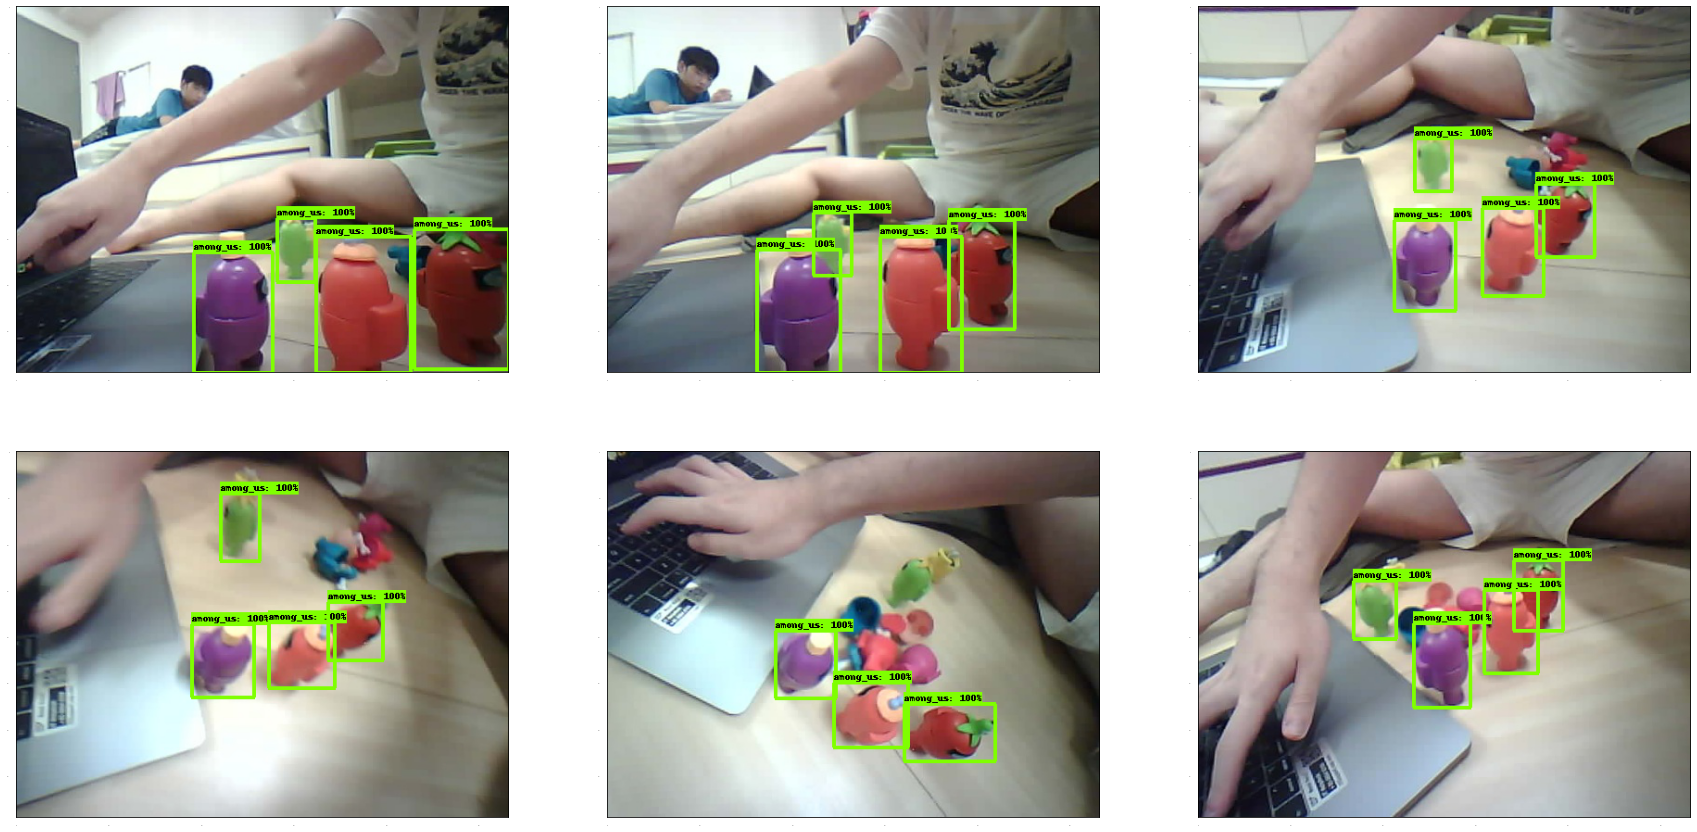

In [13]:
plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32), category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [75]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz'
mv: rename ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint to models/research/object_detection/test_data/: No such file or directory


In [6]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'new_config/pipeline.config'
checkpoint_path = 'test_data/checkpoint/ckpt-2'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [64]:
new_pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(new_pipeline_proto, 'new_config')
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(exported_ckpt, directory="test_data/checkpoint/", max_to_keep=5)

INFO:tensorflow:Writing pipeline config file to new_config/pipeline.config


INFO:tensorflow:Writing pipeline config file to new_config/pipeline.config


In [65]:
ckpt_manager.save()
print('Checkpoint saved!')

Checkpoint saved!


In [67]:
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path ./new_config/pipeline.config --trained_checkpoint_dir ./test_data/checkpoint --output_directory ./workspace/exported-models\my_ssd



2021-04-12 17:21:48.023143: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-12 17:21:48.023306: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0412 17:21:48.170940 4558020096 deprecation.py:599] From /Users/i541891/anaconda3/lib/python3.8/site-packages/object_detection/exporter_lib_v2.py:106: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Inst

W0412 17:22:24.030584 4558020096 save.py:236] Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxPredictor_layer_call_fn while saving (showing 5 of 315). These functions will not be directly callable after loading.
INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9609039be0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9609039eb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f960903d040>, TensorSpec(shape=(None, 20, 20, 2048

W0412 17:22:25.213109 4558020096 save.py:236] Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxPredictor_layer_call_fn while saving (showing 5 of 315). These functions will not be directly callable after loading.
INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9609039be0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9609039eb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f960903d040>, TensorSpec(shape=(None, 20, 20, 2048

# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 8
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  #@tf.function(experimental_relax_shapes=True)
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

[<tf.Variable 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0' shape=(3, 3, 256, 24) dtype=float32, numpy=
array([[[[-1.43162776e-02, -1.12703699e-03,  6.85368851e-03, ...,
           7.84613471e-03, -2.03802790e-02, -1.38331810e-02],
         [-6.85031060e-03,  6.63003558e-03,  1.40779801e-02, ...,
           1.80081092e-02, -7.02890242e-03, -7.55877327e-03],
         [-5.26739238e-03,  5.11108432e-03, -2.04349504e-04, ...,
          -1.99449770e-02, -4.38697636e-02,  6.31224364e-03],
         ...,
         [-1.51920505e-02,  4.07027034e-03, -1.09245023e-02, ...,
           6.56115729e-03, -4.20712167e-03,  2.41601244e-02],
         [ 8.03292030e-04, -2.44914498e-02, -7.04668183e-03, ...,
          -1.13186147e-02, -1.14144047e-03,  1.24635622e-02],
         [-3.50269233e-03, -2.55698012e-03, -1.21219670e-02, ...,
           1.29109388e-02,  1.49589661e-03, -6.97501469e-03]],

        [[-1.03469659e-03,  7.89343938e-03, -7.91689940e-03, ..

/Users/i541891/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 100, loss=0.07010862
batch 10 of 100, loss=0.07461337
batch 20 of 100, loss=0.08077855
batch 30 of 100, loss=0.07240765
batch 40 of 100, loss=0.08050645
batch 50 of 100, loss=0.08315945
batch 60 of 100, loss=0.08054781


In [63]:
tf.saved_model.save(detection_model,'savedmodel')

INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).
INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.pytho

INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2a90>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2d60>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2eb0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2a90>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2d60>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2eb0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baaf0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0badc0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baf10>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baaf0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0badc0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baf10>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2a90>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2d60>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2eb0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2a90>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2d60>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2eb0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baaf0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0badc0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baf10>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baaf0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0badc0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baf10>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb785b0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb78880>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd9acb789d0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31efa0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31ebb0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd19c31eb80>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2a90>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2d60>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2eb0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2a90>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2d60>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0c2eb0>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baaf0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0badc0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baf10>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baaf0>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0badc0>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd87b0baf10>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).


INFO:tensorflow:Assets written to: savedmodel/assets


INFO:tensorflow:Assets written to: savedmodel/assets


# Load test images and run inference with new model!

In [7]:
test_images_np = []

def download_test_images():
    base_path = '/Users/i541891/Documents/among_us_detection/workspace/images/test/'
    image_paths = sorted(glob.glob(f'{base_path}*.jpg',))
    return image_paths

TEST_IMAGE_PATHS = download_test_images()
print(TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path),axis=0))

['/Users/i541891/Documents/among_us_detection/workspace/images/test/100.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/110.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/30.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/40.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/50.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/60.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/70.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/80.jpg', '/Users/i541891/Documents/among_us_detection/workspace/images/test/90.jpg']


In [8]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    print(input_tensor.dtype)
    detections = detect(input_tensor)
    print(i)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

<dtype: 'float32'>
0
<dtype: 'float32'>
1
<dtype: 'float32'>
2
<dtype: 'float32'>
3
<dtype: 'float32'>
4
<dtype: 'float32'>
5
<dtype: 'float32'>
6
<dtype: 'float32'>
7
<dtype: 'float32'>
8


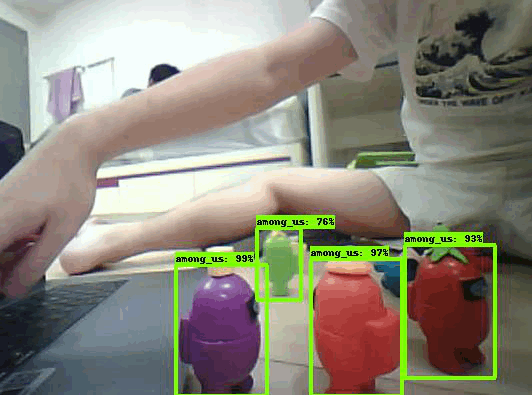

In [9]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)

display(IPyImage(open(anim_file, 'rb').read()))